In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6 as ds
from copy import copy as dup
from scipy.integrate import odeint

# Graphics parameters
%matplotlib notebook
ticklabelsize = 15
fontsize = 20
linewidth = 2
fignum = 0

In [2]:
# All the parameters
lastfile = 'NeshData/continuum_model6 8-5-2016[18][8].npz'; Load_old_file = True
nextfile = 'NeshData/continuum_model6 8-5-2016[18][9].npz'; Save_new_file = True
trajfile = 'NeshData/traj.npz'; trajflag = True
lfluxfile = 'NeshData/lflux.npz'; lateralflux = False

# Number of iterations to calculate Nliq from Ntot
niter = 1

# Loading/initializing state
if not Load_old_file:

    # Message
    print "Starting a new system"
    nx = 500 # Number of points in simulation box
    xmax = 50
    #xmax = 20
    x = np.linspace(0, xmax, nx)
    boxpoints = len(x)
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K
    Nstar = .9/(2*np.pi)
    #Nstar = .55/(2*np.pi)

    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.zeros(boxpoints)+1
    Fliq = ds.getNliq(Nice,Nstar,Nbar,niter)

else:
    
    # Message
    print "loading", lastfile
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    boxpoints = len(x)
    nx = len(x)
    deltaX = x[1]-x[0]
    
# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond
D = 0.06e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid')
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabola')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep*100, x-xmid, sigmastep_parabolic*100, '--',lw=linewidth)
#plt.ylim([19.9, 20.05])
plt.xlim([-25,25])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

loading NeshData/continuum_model6 8-5-2016[18][8].npz


<IPython.core.display.Javascript object>

In [9]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 3
else:
    countermax_0D = 1000

# 1D run 
if uselayers:
    layermax_1D = 5.0
else:
    countermax_1D = 4000
    

In [10]:
# Reporting
print "D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec'
print 'deltaT_max (Diffusion time)', dtmax
print 'deltaT =', deltaT
print 'deprate =', deprate, 'monolayers/us'
print 'nmid', nmid
print 'N*', Nstar
print 'N*x2pi', Nstar*2*np.pi
print 'Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar
print 'deltaX', deltaX
print 'sigma_0 =', sigma0
print 'sigmastepmax =', sigmastepmax
print 'center reduction', center_reduction, '%'
print 'max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec'
print 'min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec'
print 'nu_kin =', nu_kin, 'um/sec'

D = 0.0006 um^2/us 0.6 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 16.733533868
deltaT = 1.6733533868
deprate = 0.163333333333 monolayers/us
nmid 250
N* 0.143239448783
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.856760551217 0.143239448783
deltaX 0.100200400802
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49 um/sec
nu_kin = 49 um/sec


<IPython.core.display.Javascript object>


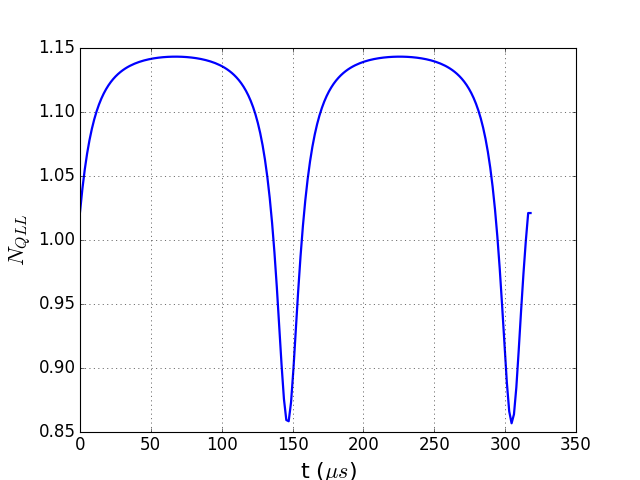

0-D Modeled growth rate, um/s 1.90932898502
0-D Modeled alpha 0.194829488267


In [11]:
# This is the 0-d run

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastepmax, sigma0, deprate]

# Initial conditions for ODE solver
y0 = [Nbar, 0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast
    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print  "0-D Modeled growth rate, um/s", growthrate_0d
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print  "0-D Modeled alpha", alpha_0d

In [12]:
growthrate_0d_mlyperus
L = xmax/2
slopefactor = nu_kin*L**2*center_reduction*sigmastepmax/D # (um/s)(um^2)(%)/(um^2/us)
slopefactorp = slopefactor/umpersec_over_mlyperus/100 # monolayers
M = 0.011; B = 4.1
NSS = M*slopefactorp + B
print 'Nss predicted =', NSS

Nss predicted = 5.03576388889


In [13]:
# This is the 1-d run

# Timing
sec1 = time.time()

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

# If we're tracking lateral flux
if lateralflux:
    params_lateral = dup(params)
    params_lateral[5] = 0 # Sets the deposition rate to zero

# Initial conditions for ODE solver
y0 = list((Fliq,Ntot))
ylast = dup(y0)

# Time steps
t0 = 0.0
tlast = dup(t0)
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True
counter = 0
lastlayer = 0
lastdiff = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT
    
    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)
    
    # Keep track of the lateral fluxes if requested
    if lateralflux:
        Fliq1 = ds.f1dflux(Fliq, Ntot, deltaT, params)
        fluxderivs = -np.diff(Fliq1)
        fluxderivskeep.append(fluxderivs)
    
    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
#         print counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

In [14]:
layer

4.0034446536166115

In [15]:
if lateralflux:
    fluxderivsmean = (np.mean(fluxderivskeep,axis=0))
#     plt.figure(6)
#     lookingat = [i for i in range(40,41)]
#     plt.plot(tkeep[1:],np.array(fluxderivskeep)[:,lookingat])
#     plt.grid('on')
#     plt.xlabel('time')

    fignum +=1
    plt.figure(fignum)
    plt.plot(x[1:]-xmid, fluxderivsmean*1e5, 'k', lw=linewidth)
    plt.grid('on')
    plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$F_{diff} \quad (arb. units)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.xlim([-25, 25])
    plt.ylim([-.6, .6])
    
    # The above is equivalent to, apart from a constant factor
#     fluxderivstrapz = []
#     for i in range(len(x)-1):
#         thisone = np.trapz(np.array(fluxderivskeep)[:,i],tkeep[1:])
#         fluxderivstrapz.append(thisone)

    
    print np.mean(fluxderivsmean[0:nmid])
    print np.mean(fluxderivsmean[nmid:])
    print fluxderivsmean[lookingat]

Height of Ice 388.058470226
1-D growth, corner 4.00344465362
1-D growth, center 4.00148459845
1-D Modeled growth rate, um/s 1.84509110535
1-D Modeled alpha, corner 0.188274602587
1-D Modeled alpha, center 0.188182424815
0-D Modeled growth rate, um/s 1.90932898502
0-D Modeled alpha 0.194829488267
Growth ratio 1D/0D 0.966355782492
Libbrecht's predicted growth rate, um/s 1.83935820632
Libbrecht's predicted alpha 0.18768961289
Time taken: 0 min 17.426017046 secs


<IPython.core.display.Javascript object>


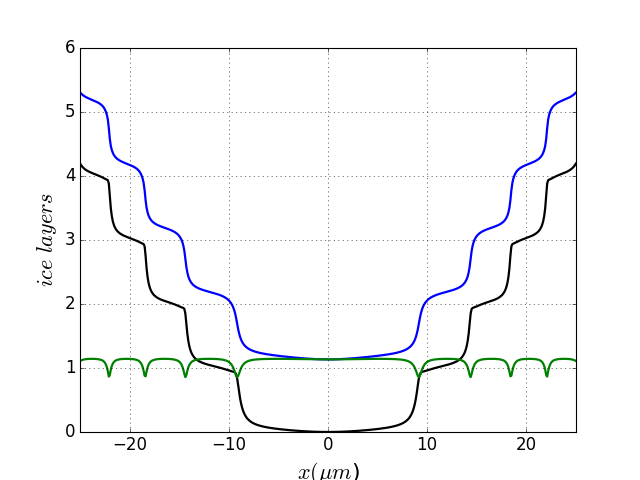

<IPython.core.display.Javascript object>


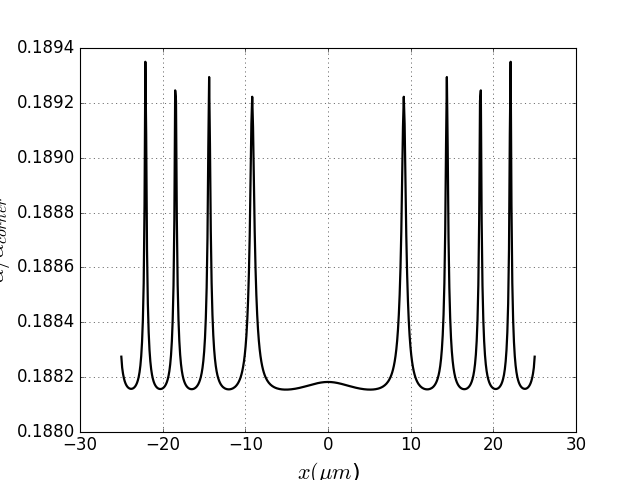

In [16]:
# Growth statistics
minpoint = min(Nice)
print"Height of Ice", minpoint
delta_Ntot_entire = Ntot-Ntotkeep[0]
print  "1-D growth, corner", delta_Ntot_entire[0]
print  "1-D growth, center", delta_Ntot_entire[nmid]
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print  "1-D Modeled growth rate, um/s", growthrate_entire[0]
alpha = growthrate_entire/nu_kin/sigmastepmax
print  "1-D Modeled alpha, corner", alpha[0]
print  "1-D Modeled alpha, center", alpha[nmid]

# Comparisons with 0-D model
print  "0-D Modeled growth rate, um/s", growthrate_0d
print  "0-D Modeled alpha", alpha_0d
print  "Growth ratio 1D/0D", growthrate_entire[0]/growthrate_0d

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print "Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax
print "Libbrecht's predicted alpha", alpha_L

# Timing statistics
sec2 = time.time()
print "Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs"

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(\
         x-xmid, Nice-minpoint, 'k', \
         x-xmid, Fliq+Nice-minpoint, 'b', \
         x-xmid, Fliq, 'g', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha /\alpha_{corner}  $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

<IPython.core.display.Javascript object>


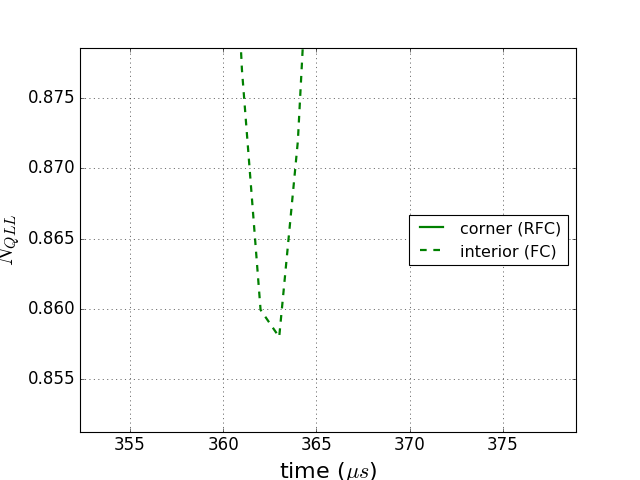

12.5250501002


In [28]:
# Getting the time dependence
if trajflag:
    fignum +=1
    plt.figure(fignum)
    #plt.plot(np.array(tkeep), np.array(Fliqkeep)[:,0], 'g-', lw=linewidth)
    #plt.plot(np.array(tkeep), np.array(Fliqkeep)[:,nmid], 'g--', lw=linewidth)
    plt.plot(np.array(Fliqkeep)[:,0], 'g-', lw=linewidth)
    plt.plot(np.array(Fliqkeep)[:,nmid], 'g--', lw=linewidth)
    #plt.plot(np.array(tkeep_0D)-145,ykeep_0Darr[:,0],lw=linewidth)
    plt.xlabel(r'time ($\mu s$)',fontsize=fontsize)
    plt.ylabel(r'$N_{QLL}$',fontsize=fontsize)
    plt.legend(['corner (RFC)','interior (FC)'],loc='center right')
    #plt.xlim([-50, 200])
    plt.grid('on')
    print x[nquart]

292
292


<IPython.core.display.Javascript object>


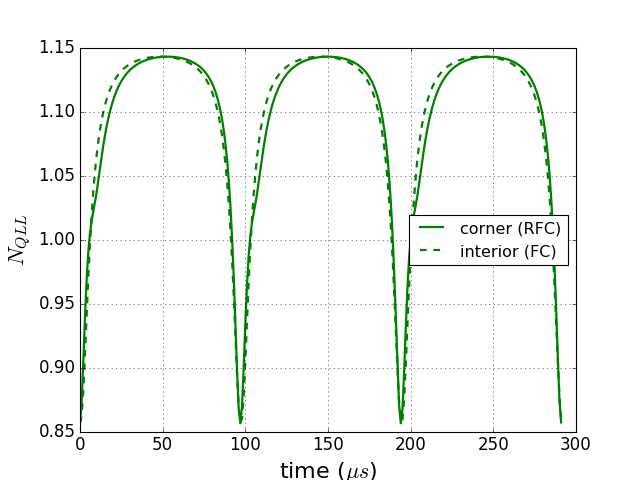

12.5250501002
42 48 14.2857142857


In [43]:
# Analysing the time dependence
if trajflag:
    irange_RFC = [i for i in range(14,306)]; print 306-14
    irange_FC = [i for i in range(71,363)]; print 363-71
    
    fignum +=1
    plt.figure(fignum)
    plt.plot(np.array(Fliqkeep)[irange_RFC,0], 'g-', lw=linewidth)
    plt.plot(np.array(Fliqkeep)[irange_FC,nmid], 'g--', lw=linewidth)
    #plt.plot(np.array(tkeep_0D)-145,ykeep_0Darr[:,0],lw=linewidth)
    plt.xlabel(r'time ($\mu s$)',fontsize=fontsize)
    plt.ylabel(r'$N_{QLL}$',fontsize=fontsize)
    plt.legend(['corner (RFC)','interior (FC)'],loc='center right')
    #plt.xlim([-50, 200])
    plt.grid('on')
    print x[nquart]
    
    # Just a rough estimate of times spent above and below midpoint
    Nmid = 0
    Ncorner = 0
    for i in range (len(tkeep)):
        if np.array(Fliqkeep)[i,0] < 1.0:
            Ncorner += 1
        if np.array(Fliqkeep)[i,nmid] < 1.0:
            Nmid += 1
    print Ncorner, Nmid, 100.*(Nmid-Ncorner)/Ncorner
    
    

In [18]:
# Saving these results to file
print Nice[0]
if Nice[0] > 100000:
    Nice -= 100000
if Save_new_file:
    print "saving to", nextfile
    np.savez_compressed(nextfile, Nice=Nice,
                        Fliq=Fliq, Nbar=Nbar, Nstar=Nstar,
                        x=x, t=ttot)

392.254140235
saving to NeshData/continuum_model6 8-5-2016[18][9].npz


In [19]:
if trajflag:
    print "saving to", trajfile
    np.savez_compressed(trajfile, Nice=Nicekeep,
                        Fliq=Fliqkeep,
                        x=x, t=tkeep)

saving to NeshData/traj.npz


In [20]:
if lateralflux:
    print "saving to", lfluxfile
    np.savez_compressed(lfluxfile, 
                        fluxderivskeep=fluxderivskeep, 
                        fluxderivsmean=fluxderivsmean,
                        x=x, t=tkeep)    